## Stock Price Prediction

Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything

We want to maximize our `true positives` - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is `true positives / (false positives + true positives)`. This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

![](ishant-mishra-UXEJDX4SqdE-unsplash.jpeg)

## Method

Before we get to the machine learning, we need to acquire and clean up the data. Here are the steps we'll follow:

- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model - Random Forest in this case
- Setup a backtesting engine
- Improve the accuracy of the model
- Calculate Profits 

## Downloading the data

First, we'll download the data from Yahoo Finance.

We'll use data for a single stock (Microsoft) from when it started trading to the present.

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

In [7]:
msft = yf.Ticker("MSFT")
msft = msft.history(period="max")

As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

- Open - the price the stock opened at.
- High - the highest price during the day
- Low - the lowest price during the day
- Close - the closing price on the trading day
- Volume - how many shares were traded

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [8]:
msft.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

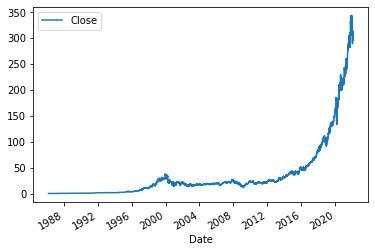

In [9]:
msft.plot.line(y='Close')

## Preparing the data

Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions!

Then, we'll combine both so we have our training data.

In [14]:
data = msft[['Close']]
data = data.rename(columns = {
    'Close':'Actual_Close'
})
data['Target'] = msft.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']

In [16]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13,0.061378,NaN
1986-03-14,0.063570,1.0
1986-03-17,0.064667,1.0
1986-03-18,0.063022,0.0
1986-03-19,0.061926,0.0


In [17]:
msft_prev = msft.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0


In [18]:
predictors = ['Close','High','Low','Open','Volume']
data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14,0.063570,1.0,0.061378,0.064119,0.055898,0.055898,1.031789e+09
1986-03-17,0.064667,1.0,0.063570,0.064667,0.061378,0.061378,3.081600e+08
1986-03-18,0.063022,0.0,0.064667,0.065215,0.063570,0.063570,1.331712e+08
1986-03-19,0.061926,0.0,0.063022,0.065215,0.062474,0.064667,6.776640e+07
1986-03-20,0.060282,0.0,0.061926,0.063570,0.061378,0.063022,4.789440e+07


## Creating a machine learning model
Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
train = data.iloc[:-100]
test = data.iloc[-100:]
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=200, random_state=1)

Next, we'll need to check how accurate the model was. Earlier, we mentioned using precision to measure error. We can do this by using the precision_score function from scikit-learn.

In [21]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
preds = pd.Series(preds, index=test.index)

In [23]:
preds

Date
2021-09-22    1.0
2021-09-23    1.0
2021-09-24    1.0
2021-09-27    1.0
2021-09-28    1.0
             ... 
2022-02-07    0.0
2022-02-08    0.0
2022-02-09    0.0
2022-02-10    0.0
2022-02-11    0.0
Length: 100, dtype: float64

In [24]:
precision_score(test['Target'], preds)

0.5

So our model is directionally accurate 50% of the time. This is only a little bit better than a coin flip! We can take a deeper look at the individual predictions and the actuals, and see where we're off.

In [25]:
combined = pd.concat({"Target": test['Target'], 'Predictions': preds}, axis=1)

In [26]:
combined

,Target,Predictions
Date,,
2021-09-22,1.0,1.0
2021-09-23,1.0,1.0
2021-09-24,0.0,1.0
2021-09-27,0.0,1.0
2021-09-28,0.0,1.0
...,...,...
2022-02-07,0.0,0.0
2022-02-08,1.0,0.0
2022-02-09,1.0,0.0


<AxesSubplot:xlabel='Date'>

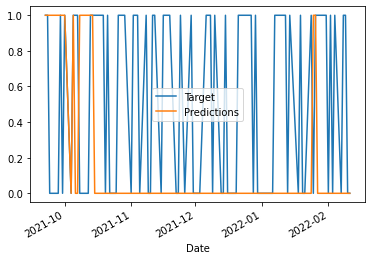

In [27]:
combined.plot()

## Backtesting

Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

- Split the training and test data
- Train a model
- Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [43]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        model.fit(train[predictors], train['Target'])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        combined = pd.concat({"Target": test['Target'], 'Predictions': preds}, axis=1)
        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions

In [47]:
predictions = backtest(data, model, predictors)

In [37]:
predictions['Predictions'].value_counts()

0.0    7331
1.0     723
Name: Predictions, dtype: int64

As you can see, we're only making 723 trades. This is because we used .6 as a threshold for trading.

In [38]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5020746887966805

## Improving accuracy
The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [39]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()['Target']

In [41]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [44]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [45]:
precision_score(predictions['Target'], predictions['Predictions'])

0.6515151515151515

In [46]:
predictions['Predictions'].value_counts()

0.0    7491
1.0     198
Name: Predictions, dtype: int64

We can see that our accuracy has significantly improved as we added more indicators. One could try adding more relevant indicators and would observe an improve in accuracy.

## Calculating Profits:

Let's now calculate our profits. If we were to start with 100 dollars and invest on days that our algorithm suggested, we would end up with around 292 dollars which seems like a good profit, however the time frame seems too large.

In [63]:
profit_days = predictions[predictions['Predictions'] == 1].index
percentage_change = (msft.loc[profit_days]['Close'] - msft.loc[profit_days]['Open'])/msft.loc[profit_days]['Open']
amount = 100
for i in (percentage_change+1):
    amount *= i
amount

292.95853068698904

## Conclusion:

In this project, we predicted days where the Microsoft stock price would go up. Our approach had a precision of 65% which means the number of times our algorithm suggested to buy the stock, 65% of the times it was correct.

We could build more complex models by changing hyperparameters of the Random Forest or by trying a different algorithm altogether.